## 0. Libarary 불러오기 및 경로설정

`!pip install -U albumentations==0.5.2`

`!pip install timm`

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import time
import datetime
import albumentations
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from PIL import Image
from copy import deepcopy
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from pytz import timezone
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.nn.modules.loss import _WeightedLoss

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('PyTorch version: {}'.format(torch.__version__))

PyTorch version: 1.7.1


In [4]:
# 부를 수 있는 모델 확인
all_vit_models = timm.list_models('*efficient*')
all_vit_models

['eca_efficientnet_b0',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_s',
 'gc_efficientnet_b0',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns',
 'tf_efficientnet_b2',
 'tf_efficientnet_b2_ap',
 'tf_efficien

## RANDOM SEED 고정

In [5]:
def set_seed(SEED):
    # Set random seed
    # random.seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

## Pretrained Model Class 정의

In [6]:
class ImgClassifier(nn.Module):
    def __init__(self, model_name, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Fine Tuning & Feature extractor 설정 함수 정의

In [7]:
def set_model_train_mode(model, mode=0):
    # Fine Tuning
    if mode == 0:
        for param in model.parameters():
            param.requires_grad = True
    # Feature extractor
    elif mode == 1:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        raise Exception('mode를 0: Fine Tuning 1: Feature extractor 를 위한 parameter를 넣으세요!')

## Dataset Class 정의

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, transform):
        self.img_paths = df['image_path']
        self.transform = transform
        self.y = df['target']

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_paths.iloc[idx]))
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image, torch.tensor(label)

## 데이터 Augmentation 을 위한 transform 정의 (albumentations 사용)

In [9]:
def get_transform(mean, std):
    train_transform = albumentations.Compose([
        albumentations.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, p=1.0),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5),
        albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        albumentations.GaussNoise(p=0.5),
        albumentations.Normalize(mean, std, max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ])
    valid_transform = albumentations.Compose([
        albumentations.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
        albumentations.Normalize(mean, std, max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ])
    return train_transform, valid_transform

## 3. Train DataLoader 정의

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, transform):
        self.img_paths = df['image_path']
        self.transform = transform
        self.y = df['target']

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_paths.iloc[idx]))
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image, torch.tensor(label)

In [18]:
def get_dataloader(df, train_idx, valid_idx, mean, std):
    
    train_ = df.iloc[train_idx].reset_index(drop=True)
    valid_ = df.iloc[valid_idx].reset_index(drop=True)
    
    train_transform, valid_transform = get_transform(mean, std)
    
    train_dataset = MyDataset(train_, train_transform)
    valid_dataset = MyDataset(valid_, valid_transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=cfg.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=cfg.NUM_WORKERS)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                               batch_size=cfg.BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=cfg.NUM_WORKERS)
    
    return train_loader, valid_loader

## EarlyStopping Class 정의

In [25]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, fold, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.fold = fold
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        path = f'{os.path.join(cfg.model_save_path, cfg.model_name)}_{self.fold + 1}'
        my_make_dir(path)
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

## Train_one_epoch 함수 정의

In [20]:
def train_one_epoch(epoch, model, criterion, optimizer, train_loader, device):
    model.train()
    
    running_loss = 0
    running_acc = 0
    running_f1 = 0
    
    pbar = tqdm(train_loader, total=len(train_loader))
    for X_batch, y_batch in pbar:
        pbar.set_description(f'Epoch {epoch} | loss : {running_loss:.4f} | acc : {running_acc:.4f} | F1_score : {running_f1:.4f}')

        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).long()
        
        optimizer.zero_grad()
        
        y_pred = model.forward(X_batch)
        _, preds = torch.max(y_pred, 1)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
        running_f1 += f1_score(preds.cpu().numpy(), 
                                     y_batch.cpu().numpy(), average='macro')
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    epoch_f1 = running_f1 / len(train_loader)
    
    return epoch_loss, epoch_acc, epoch_f1

## Valid_one_epoch 함수 정의

In [21]:
def valid_one_epoch(epoch, model, criterion, valid_loader, device):
    model.eval()
    
    running_loss = 0
    running_acc = 0
    running_f1 = 0
    
    pbar = tqdm(valid_loader, total=len(valid_loader))
    with torch.no_grad():
        for X_batch, y_batch in pbar:
            pbar.set_description(f'Epoch {epoch} | loss : {running_loss:.4f} | acc : {running_acc:.4f} | F1_score : {running_f1:.4f}')
            
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).long()
            
            y_pred = model.forward(X_batch)
            _, preds = torch.max(y_pred, 1)
            loss = criterion(y_pred, y_batch)
            
            running_loss += loss.item()
            running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
            running_f1 += f1_score(preds.cpu().numpy(), 
                                     y_batch.cpu().numpy(), average='macro')
            
    epoch_loss = running_loss / len(valid_loader)
    epoch_acc = running_acc / len(valid_loader)
    epoch_f1 = running_f1 / len(valid_loader)
    
    return epoch_loss, epoch_acc, epoch_f1

## 폴더 자동 생성 함수 정의

In [22]:
def my_make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

## Config 정의

In [23]:
class cfg:
    train_dir = '/opt/ml/input/data/train'
    img_dir = f'{train_dir}/images'
    df_path = f'{train_dir}/train_with_label.csv'
    
    model_save_path = '/opt/ml/code/model'
    sumission_save_path = '/opt/ml/code/submission'
    
    test_dir = '/opt/ml/input/data/eval'
    submission_dir = '{}/{}'.format(
        sumission_save_path,
        datetime.datetime.today().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d")
    )
    SEED = 2021
    EPOCHS = 10
    BATCH_SIZE = 128
    LEARNING_RATE = 0.001
    CLASS_NUM = 18
    IMAGE_SIZE = 224
    PATIENCE = 5
    FOLD_NUM = 5
    weight_decay = 1e-6
    NUM_WORKERS = 1
    
    mean_list = [0.5, 0.5, 0.5]
    std_list = [0.2, 0.2, 0.2]
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model_name = 'tf_efficientnet_b4_ns'

In [27]:
# 메인 학습 코드
start = time.time()

df = pd.read_csv(os.path.join(cfg.train_dir, 'train_with_label.csv'))

# 5개의 KFold
folds = StratifiedKFold(n_splits=cfg.FOLD_NUM, 
                        shuffle=True, 
                        random_state=cfg.SEED)
folds = folds.split(np.arange(len(df)), df['target'].values)

for fold, (train_idx, valid_idx) in enumerate(folds):
    if fold > 0:
        break
        
    print(f'Training with {fold + 1} started')
    
    print(len(train_idx), len(valid_idx))
    
    # train_df 이미지의 pixel 값의 mean & std
    train_loader, valid_loader = get_dataloader(df, train_idx, valid_idx, 
                                                cfg.mean_list, cfg.std_list)
    
    device = cfg.device
    model = ImgClassifier(model_name=cfg.model_name, 
                          n_class=cfg.CLASS_NUM, 
                          pretrained=True).to(device)
    set_model_train_mode(model, 0)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    earlystop = EarlyStopping(fold=fold, patience=cfg.PATIENCE, verbose=True)    

    
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []

    best_loss = 0.0
    
    for epoch in range(1, cfg.EPOCHS + 1):
        train_epoch_loss, train_epoch_acc, train_epoch_f1 = \
        train_one_epoch(epoch, model, criterion, optimizer, train_loader, device)
        scheduler.step()
        
        train_loss_history.append(train_epoch_loss)
        train_acc_history.append(train_epoch_acc)
        train_f1_history.append(train_epoch_f1)
        print(f'Train Loss : {train_epoch_loss:.4f}, Accuracy : {train_epoch_acc:.4f}, F1_score : {train_epoch_f1:.4f}')
        with torch.no_grad():
            valid_epoch_loss, valid_epoch_acc, valid_epoch_f1 = \
            valid_one_epoch(epoch, model, criterion, valid_loader, device)
            
            val_loss_history.append(valid_epoch_loss)
            val_acc_history.append(valid_epoch_acc)
            val_f1_history.append(valid_epoch_f1)
            
        print(f'Validation Loss : {valid_epoch_loss:.4f}, Accuracy : {valid_epoch_acc:.4f}, F1_score : {valid_epoch_f1:.4f}')
        
        if valid_epoch_loss > best_loss:
            best_loss = valid_epoch_loss
            
        earlystop(valid_epoch_loss, model)
    
        if earlystop.early_stop:
            print('Early stopping')
            model.load_state_dict(torch.load(f'{os.path.join(cfg.model_save_path, cfg.model_name)}_{fold + 1}/checkpoint.pt'))
            break
            
    print('Best Validation loss: {:.4f}'.format(best_loss))
    print('{}번째 학습 종료!'.format(fold + 1))
    
    del model, optimizer, train_loader, val_loader, scheduler
    torch.cuda.empty_cache()
    
end = time.time()
print('총 걸린 시간 : {}'.format(end - start))

Training with 1 started
15120 3780



Train Loss : 0.5178, Accuracy : 0.8418, F1_score : 0.7036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join


Validation Loss : 0.2244, Accuracy : 0.9236, F1_score : 0.8287
Validation loss decreased (inf --> 0.224372).  Saving model ...



Train Loss : 0.2070, Accuracy : 0.9319, F1_score : 0.8596



Validation Loss : 0.1363, Accuracy : 0.9527, F1_score : 0.8507
Validation loss decreased (0.224372 --> 0.136307).  Saving model ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join


Train Loss : 0.1051, Accuracy : 0.9650, F1_score : 0.9208


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join


Validation Loss : 0.1013, Accuracy : 0.9691, F1_score : 0.9185
Validation loss decreased (0.136307 --> 0.101304).  Saving model ...



Train Loss : 0.0891, Accuracy : 0.9693, F1_score : 0.9374



Validation Loss : 0.1148, Accuracy : 0.9599, F1_score : 0.8628
EarlyStopping counter: 1 out of 5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



Train Loss : 0.0845, Accuracy : 0.9713, F1_score : 0.9366



Validation Loss : 0.0756, Accuracy : 0.9758, F1_score : 0.9151
Validation loss decreased (0.101304 --> 0.075599).  Saving model ...



Train Loss : 0.0812, Accuracy : 0.9730, F1_score : 0.9412



Validation Loss : 0.0758, Accuracy : 0.9719, F1_score : 0.9411
EarlyStopping counter: 1 out of 5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers


    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



Train Loss : 0.0542, Accuracy : 0.9816, F1_score : 0.9661



Validation Loss : 0.0898, Accuracy : 0.9708, F1_score : 0.9297
EarlyStopping counter: 2 out of 5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



Train Loss : 0.0210, Accuracy : 0.9936, F1_score : 0.9876



Validation Loss : 0.0125, Accuracy : 0.9961, F1_score : 0.9932
Validation loss decreased (0.075599 --> 0.012533).  Saving model ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join


Train Loss : 0.0115, Accuracy : 0.9965, F1_score : 0.9943


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join


Validation Loss : 0.0099, Accuracy : 0.9974, F1_score : 0.9952
Validation loss decreased (0.012533 --> 0.009878).  Saving model ...



Train Loss : 0.0083, Accuracy : 0.9979, F1_score : 0.9955



Validation Loss : 0.0097, Accuracy : 0.9974, F1_score : 0.9934
Validation loss decreased (0.009878 --> 0.009738).  Saving model ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



Train Loss : 0.0066, Accuracy : 0.9980, F1_score : 0.9943


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join


Validation Loss : 0.0085, Accuracy : 0.9977, F1_score : 0.9960
Validation loss decreased (0.009738 --> 0.008535).  Saving model ...



Train Loss : 0.0058, Accuracy : 0.9989, F1_score : 0.9972



Validation Loss : 0.0080, Accuracy : 0.9982, F1_score : 0.9977
Validation loss decreased (0.008535 --> 0.008040).  Saving model ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efef659a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


KeyboardInterrupt: 

## 학습 그래프 표출 함수 정의

In [29]:
def show_graph(train_loss_history, train_acc_history, train_f1_history,
               val_loss_history, val_acc_history, val_f1_history):
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    
    axes[0].plot(train_loss_history, label='train_loss')
    axes[0].plot(val_loss_history, label='val_loss')
    axes[1].plot(train_acc_history, label='train_acc')
    axes[1].plot(val_acc_history, label='val_acc')
    axes[2].plot(train_f1_history, label='train_f1')
    axes[2].plot(val_f1_history, label='val_f1')

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()

    plt.show()

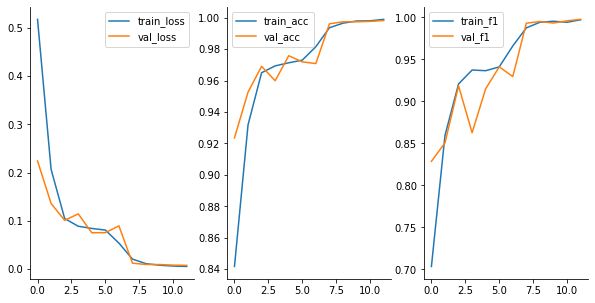

In [30]:
show_graph(train_loss_history, train_acc_history, train_f1_history,
           val_loss_history, val_acc_history, val_f1_history)

## Inference 과정

In [31]:
# sumission_dir 생성
my_make_dir(cfg.submission_dir)

## 6.1 Test Dataset 정의

In [32]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = np.array(Image.open(self.img_paths[index]))

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [33]:
sorted(glob.glob(os.path.join(cfg.model_save_path, cfg.model_name) + '_*/checkpoint.pt'))

['/opt/ml/code/model/tf_efficientnet_b4_ns_1/checkpoint.pt']

In [34]:
test_transform = albumentations.Compose([
    albumentations.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
    albumentations.Normalize(cfg.mean_list, cfg.std_list, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0),
])

In [35]:
# 테스트셋 추론 메인 코드

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(cfg.test_dir, 'info.csv'))
image_dir = os.path.join(cfg.test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, test_transform)

loader = DataLoader(
    dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=cfg.NUM_WORKERS,
)

# KFOLD를 이용한 모델 5개의 checkpoint.pt path
checkpoint_path_list = sorted(glob.glob(os.path.join(cfg.model_save_path, 
                                                     cfg.model_name) + '_*/checkpoint.pt'))
for i, checkpoint_path in enumerate(checkpoint_path_list):
    # 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
    model = ImgClassifier(model_name=cfg.model_name, 
                          n_class=cfg.CLASS_NUM, 
                          pretrained=False).to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
    all_predictions = []
    for images in tqdm(loader):
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    submission['ans'] = all_predictions

    # 제출할 파일을 저장합니다.
    submission.to_csv(os.path.join(cfg.submission_dir, 
                                   'submission_{}.csv'.format(checkpoint_path.split('/')[-2])), 
                      index=False)
    
    print(f'{i + 1} 번째 sumission file 생성!')
print('test inference is done!')


1 번째 sumission file 생성!
test inference is done!


In [39]:
submission_file_list = glob.glob(os.path.join(cfg.submission_dir, 
                                             'submission_{}_*'.format(cfg.model_name)))

In [40]:
submission_file_list

['/opt/ml/code/submission/2021-08-26/submission_tf_efficientnet_b4_ns_1.csv']

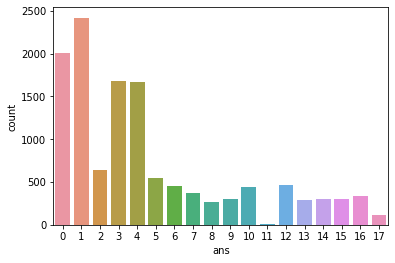

In [42]:
import seaborn as sns
result_df = pd.read_csv(submission_file_list[0])
sns.countplot(result_df['ans'])

In [36]:
for i, file in enumerate(submission_file_list):
    if i == 0:
        result_df = pd.read_csv(file)
        result_df.rename({'ans': 'ans_1'}, axis=1, inplace=True)
    else:
        temp_df = pd.read_csv(file)
        result_df['ans_{}'.format(i + 1)] = temp_df['ans']
        
result_df['ans'] = result_df.apply(lambda x: x.iloc[1:].value_counts().index[0], axis=1)
result_df.drop(['ans_{}'.format(i) for i in range(1, 6)], axis=1, inplace=True)
result_df.to_csv(os.path.join(cfg.submission_dir, 
                              'submission_{}_ensemble.csv'.format(cfg.model_name)),
                 index=False)

KeyError: "['ans_2' 'ans_3' 'ans_4' 'ans_5'] not found in axis"